In [1]:
import numpy as np

# 读取两个文件
def load_tensor_files():
    # 读取第一个文件
    try:
        tensor_88 = np.loadtxt('yolov8n_88_result.txt')
        print("成功读取 yolov8n_88_result.txt")
        print(f"张量形状: {tensor_88.shape}")
    except Exception as e:
        print(f"读取 yolov8n_88_result.txt 时出错: {e}")
        tensor_88 = None
    
    # 读取第二个文件
    try:
        tensor_normal = np.loadtxt('yolov8n_result.txt')
        print("成功读取 yolov8n_result.txt")
        print(f"张量形状: {tensor_normal.shape}")
    except Exception as e:
        print(f"读取 yolov8n_result.txt 时出错: {e}")
        tensor_normal = None
        
    return tensor_88, tensor_normal

# 调用函数读取文件
tensor_88, tensor_normal = load_tensor_files()

成功读取 yolov8n_88_result.txt
张量形状: (8400, 144)
成功读取 yolov8n_result.txt
张量形状: (8400, 144)


In [2]:
# 将tensor_normal转换为多尺度特征图格式
def reshape_tensor_normal():
    if tensor_normal is None:
        print("tensor_normal 数据不可用")
        return None
        
    # 计算每个特征图的大小
    s1 = 80 * 80  # 第一个特征图大小
    s2 = 40 * 40  # 第二个特征图大小 
    s3 = 20 * 20  # 第三个特征图大小
    
    # 分割tensor_normal
    feat1 = tensor_normal[:s1].reshape(80, 80, 144, 1)
    feat2 = tensor_normal[s1:s1+s2].reshape(40, 40, 144, 1)
    feat3 = tensor_normal[s1+s2:s1+s2+s3].reshape(20, 20, 144, 1)
    
    return [feat1, feat2, feat3]

# 转换tensor_normal
multi_scale_features_normal = reshape_tensor_normal()
if multi_scale_features_normal:
    print("转换后的特征图形状:")
    for i, feat in enumerate(multi_scale_features_normal):
        print(f"特征图 {i+1}: {feat.shape}")


转换后的特征图形状:
特征图 1: (80, 80, 144, 1)
特征图 2: (40, 40, 144, 1)
特征图 3: (20, 20, 144, 1)


In [3]:
# 将tensor_88转换为多尺度特征图格式
def reshape_tensor_88():
    if tensor_88 is None:
        print("tensor_88 数据不可用")
        return None
        
    # 计算每个特征图的大小
    s1 = 80 * 80  # 第一个特征图大小
    s2 = 40 * 40  # 第二个特征图大小 
    s3 = 20 * 20  # 第三个特征图大小
    
    # 分割tensor_88
    feat1 = tensor_88[:s1].reshape(144, 80, 80,  1)
    feat2 = tensor_88[s1:s1+s2].reshape(144, 40, 40,  1)
    feat3 = tensor_88[s1+s2:s1+s2+s3].reshape(144, 20, 20,  1)
    
    return [feat1, feat2, feat3]

# 转换tensor_88
multi_scale_features_88 = reshape_tensor_88()
if multi_scale_features_88:
    print("转换后的特征图形状:")
    for i, feat in enumerate(multi_scale_features_88):
        print(f"特征图 {i+1}: {feat.shape}")


转换后的特征图形状:
特征图 1: (144, 80, 80, 1)
特征图 2: (144, 40, 40, 1)
特征图 3: (144, 20, 20, 1)


In [4]:
import numpy as np
from typing import List, Tuple
import torch
import torch.nn.functional as F

class YOLOv8PostProcessor:
    def __init__(self, num_classes: int = 80, conf_threshold: float = 0.3, iou_threshold: float = 0.4):
        self.num_classes = num_classes
        self.conf_threshold = conf_threshold
        self.iou_threshold = iou_threshold
        self.coco_names = ["person","bicycle","car","motorbike","aeroplane","bus","train","truck","boat","traffic light","fire hydrant","stop sign","parking meter","bench","bird","cat","dog","horse","sheep","cow","elephant","bear","zebra","giraffe","backpack","umbrella","handbag","tie","suitcase","frisbee","skis","snowboard","sports ball","kite","baseball bat","baseball glove","skateboard","surfboard","tennis racket","bottle","wine glass","cup","fork","knife","spoon","bowl","banana","apple","sandwich","orange","broccoli","carrot","hot dog","pizza","donut","cake","chair","sofa","pottedplant","bed","diningtable","toilet","tvmonitor","laptop","mouse","remote","keyboard","cell phone","microwave","oven","toaster","sink","refrigerator","book","clock","vase","scissors","teddy bear","hair drier","toothbrush"
                         ]
    
    def _process_predictions(self, predictions: np.ndarray, grid_size: Tuple[int, int]) -> Tuple[np.ndarray, np.ndarray]:
        """处理单个尺度的预测结果"""
        height, width = grid_size
        boxes = []
        scores = []
        
        for i in range(height):
            for j in range(width):
                pred = predictions[i * width + j]
                
                # 处理分类scores (前80个值)
                cls_scores = 1 / (1 + np.exp(-pred[:self.num_classes]))  # sigmoid
                max_score = np.max(cls_scores)
                
                if max_score > self.conf_threshold:
                    # 处理边界框 (后64个值，每16个值表示一个坐标)
                    box_data = pred[self.num_classes:]
                    box_coords = []
                    
                    for k in range(4):
                        values = box_data[k*16:(k+1)*16]
                        values = np.exp(values)
                        values = values / np.sum(values)
                        coord = np.sum(np.arange(16) * values)
                        box_coords.append(coord)
                    
                    # 转换为 [x, y, w, h] 格式
                    x = (j + 0.5 - box_coords[0]) / width
                    y = (i + 0.5 - box_coords[1]) / height
                    w = (j + 0.5 + box_coords[2]) / width - x
                    h = (i + 0.5 + box_coords[3]) / height - y
                    
                    # 转换为中心点格式
                    x = x + w/2
                    y = y + h/2
                    
                    boxes.append([x, y, w, h])
                    scores.append(cls_scores)
        
        return np.array(boxes), np.array(scores)

    def _nms(self, boxes: np.ndarray, scores: np.ndarray) -> List[int]:
        """非极大值抑制"""
        x1 = boxes[:, 0] - boxes[:, 2]/2
        y1 = boxes[:, 1] - boxes[:, 3]/2
        x2 = boxes[:, 0] + boxes[:, 2]/2
        y2 = boxes[:, 1] + boxes[:, 3]/2
        
        areas = (x2 - x1) * (y2 - y1)
        order = scores.argsort()[::-1]
        
        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)
            
            xx1 = np.maximum(x1[i], x1[order[1:]])
            yy1 = np.maximum(y1[i], y1[order[1:]])
            xx2 = np.minimum(x2[i], x2[order[1:]])
            yy2 = np.minimum(y2[i], y2[order[1:]])
            
            w = np.maximum(0.0, xx2 - xx1)
            h = np.maximum(0.0, yy2 - yy1)
            inter = w * h
            
            ovr = inter / (areas[i] + areas[order[1:]] - inter)
            inds = np.where(ovr <= self.iou_threshold)[0]
            order = order[inds + 1]
            
        return keep

    def process(self, multi_scale_features: List[np.ndarray]) -> List[dict]:
        """处理多尺度特征图"""
        all_boxes = []
        all_scores = []
        
        # 处理三个尺度的预测
        for feat, size in zip(multi_scale_features, [(80,80), (40,40), (20,20)]):
            feat = feat.reshape(-1, 144)  # 展平特征图
            boxes, scores = self._process_predictions(feat, size)
            all_boxes.extend(boxes)
            all_scores.extend(scores)
            
        all_boxes = np.array(all_boxes)
        all_scores = np.array(all_scores)
        
        # 对每个类别进行NMS
        results = []
        for cls_idx in range(self.num_classes):
            cls_scores = all_scores[:, cls_idx]
            mask = cls_scores > self.conf_threshold
            if not np.any(mask):
                continue
                
            cls_boxes = all_boxes[mask]
            cls_scores = cls_scores[mask]
            
            keep = self._nms(cls_boxes, cls_scores)
            
            for idx in keep:
                results.append({
                    'class_id': cls_idx,
                    'class_name': self.coco_names[cls_idx],
                    'confidence': float(cls_scores[idx]),
                    'bbox': cls_boxes[idx].tolist()  # [x, y, w, h]
                })
                
        return results

In [5]:
import cv2
import numpy as np
from typing import List, Dict

def obj_id_to_color(obj_id: int) -> tuple:
    """
    生成不同类别的颜色
    
    Args:
        obj_id: 类别ID
    
    Returns:
        tuple: BGR颜色值
    """
    colors = [
        (255, 0, 255),  # 粉红 (B,G,R)
        (255, 0, 0),    # 蓝色
        (255, 255, 0),  # 青色
        (0, 255, 0),    # 绿色
        (0, 255, 255),  # 黄色
        (0, 0, 255),    # 红色
    ]
    
    color_index = (obj_id * 123457) % 6
    color_scale = 150 + (obj_id * 123457) % 100
    color = np.array(colors[color_index]) * (color_scale / 255.0)
    return tuple(map(int, color))

def draw_results(image: np.ndarray, detection_results: List[Dict]) -> np.ndarray:
    """
    在图像上绘制检测结果
    
    Args:
        image: 原始图像
        detection_results: 检测结果列表，每个元素为字典，包含class_id, class_name, confidence, bbox
    
    Returns:
        np.ndarray: 绘制了检测框的图像
    """
    img_height, img_width = image.shape[:2]
    
    for det in detection_results:
        # 获取边界框坐标 (转换从相对坐标到绝对坐标)
        x, y, w, h = det['bbox']
        left = int((x - w/2) * img_width)
        right = int((x + w/2) * img_width)
        top = int((y - h/2) * img_height)
        bottom = int((y + h/2) * img_height)
        
        # 确保坐标在图像范围内
        left = max(0, min(left, img_width))
        right = max(0, min(right, img_width))
        top = max(0, min(top, img_height))
        bottom = max(0, min(bottom, img_height))
        
        # 获取该类别的颜色
        color = obj_id_to_color(det['class_id'])
        
        # 绘制边界框
        cv2.rectangle(image, (left, top), (right, bottom), color, 2)
        
        # 准备标签文本
        label = f"{det['class_name']}: {det['confidence']*100:.0f}%"
        
        # 获取文本大小
        (label_width, label_height), baseline = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_COMPLEX, 0.5, 1
        )
        
        # 绘制标签背景
        cv2.rectangle(
            image,
            (left, top - label_height - 10),
            (left + label_width + 10, top),
            color,
            -1
        )
        
        # 绘制标签文本
        cv2.putText(
            image,
            label,
            (left + 5, top - 5),
            cv2.FONT_HERSHEY_COMPLEX,
            0.5,
            (0, 0, 0),  # 黑色文本
            1
        )
    
    return image

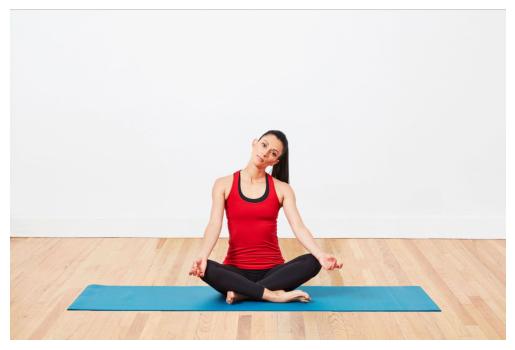

In [6]:
import matplotlib.pyplot as plt
# 读取图像
image_path = "test_img.jpg"
image = cv2.imread(image_path)
if image is None:
    print(f"无法读取图像: {image_path}")
    exit()

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show() 

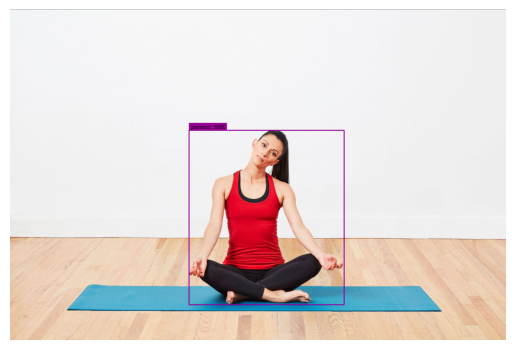

In [7]:
result_88_image = draw_results(image.copy(), YOLOv8PostProcessor().process(multi_scale_features_88))

plt.imshow(cv2.cvtColor(result_88_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

调整后 multi_scale_features_normal_adjusted[0].shape: (144, 80, 80, 1)
调整后 multi_scale_features_normal_adjusted[1].shape: (144, 40, 40, 1)
调整后 multi_scale_features_normal_adjusted[2].shape: (144, 20, 20, 1)


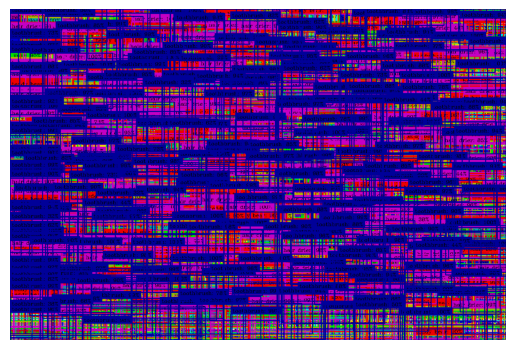

In [8]:
# 调整 multi_scale_features_normal 的维度顺序
multi_scale_features_normal_adjusted = []
for feature in multi_scale_features_normal:
    # 将维度从 (H, W, C, 1) 调整为 (C, H, W, 1)
    adjusted_feature = np.transpose(feature, (2, 0, 1, 3))
    multi_scale_features_normal_adjusted.append(adjusted_feature)

# 打印调整后的形状以验证
for i in range(3):
    print(f"调整后 multi_scale_features_normal_adjusted[{i}].shape: {multi_scale_features_normal_adjusted[i].shape}")
multi_scale_features_normal = multi_scale_features_normal_adjusted

# 绘制检测结果
normal_result_image = draw_results(image.copy(), YOLOv8PostProcessor().process(multi_scale_features_normal))
    
plt.imshow(cv2.cvtColor(normal_result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()